In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt

2024-08-18 07:08:43.764901: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-18 07:08:43.765003: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-18 07:08:43.896769: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Load the CSV file
df = pd.read_csv('/kaggle/input/pad-ufes-20/PAD-UFES-20/metadata.csv')
data=df[['diagnostic','img_id']]
data.head()

,diagnostic,img_id
0,NEV,PAT_1516_1765_530.png
1,BCC,PAT_46_881_939.png
2,ACK,PAT_1545_1867_547.png
3,ACK,PAT_1989_4061_934.png
4,BCC,PAT_684_1302_588.png


In [3]:
class_map = {label: idx for idx, label in enumerate(data['diagnostic'].unique())}
class_map

{'NEV': 0, 'BCC': 1, 'ACK': 2, 'SEK': 3, 'SCC': 4, 'MEL': 5}

In [4]:
class_map = {label: idx for idx, label in enumerate(data['diagnostic'].unique())}
data['targets'] = data['diagnostic'].map(class_map)

/tmp/ipykernel_33/3493205703.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['targets'] = data['diagnostic'].map(class_map)


In [5]:
data.head()

,diagnostic,img_id,targets
0,NEV,PAT_1516_1765_530.png,0
1,BCC,PAT_46_881_939.png,1
2,ACK,PAT_1545_1867_547.png,2
3,ACK,PAT_1989_4061_934.png,2
4,BCC,PAT_684_1302_588.png,1


In [6]:
data.targets.unique()

array([0, 1, 2, 3, 4, 5])

In [7]:
data['targets']=data['targets'].astype('int64')

/tmp/ipykernel_33/2052663019.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['targets']=data['targets'].astype('int64')


In [8]:
data.head()

,diagnostic,img_id,targets
0,NEV,PAT_1516_1765_530.png,0
1,BCC,PAT_46_881_939.png,1
2,ACK,PAT_1545_1867_547.png,2
3,ACK,PAT_1989_4061_934.png,2
4,BCC,PAT_684_1302_588.png,1


In [9]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(data['targets']), y=data['targets'])
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: 1.569672131147541,
 1: 0.4532544378698225,
 2: 0.5246575342465754,
 3: 1.6297872340425532,
 4: 1.9947916666666667,
 5: 7.365384615384615}

In [10]:
# Function to load images
def load_images(img_paths, img_size=(224, 224)):
    images = []
    for path in img_paths:
        img = tf.keras.preprocessing.image.load_img(path, target_size=img_size)
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = img / 255.0  # Normalize to [0, 1]
        images.append(img)
    return np.array(images)

# Load images
img_paths = data['img_id'].values
images = load_images('/kaggle/input/pad-ufes-20/PAD-UFES-20/Dataset'+'/'+img_paths)

# Extract labels
labels = data['targets'].values

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,            # Normalize the images
    rotation_range=40,         # Randomly rotate images by up to 40 degrees
    width_shift_range=0.2,     # Randomly shift images horizontally by up to 20% of the width
    height_shift_range=0.2,    # Randomly shift images vertically by up to 20% of the height
    shear_range=0.2,           # Randomly apply shear transformations
    zoom_range=0.2,            # Randomly zoom into images
    horizontal_flip=True,      # Randomly flip images horizontally
    fill_mode='nearest'        # Fill in newly created pixels after a transformation
)

# No data augmentation for validation, only rescaling
val_datagen = ImageDataGenerator(rescale=1./255)

# Create generators

train_generator = train_datagen.flow(X_train, y_train, batch_size=32,shuffle=True)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32,shuffle=False)

In [15]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# Define ResNet50 base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

input_tensor = base_model.input

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256,activation='relu',kernel_regularizer=l2(0.01))(x)  # Reduce the dense layer size and increase L2 regularization
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)  # Increase dropout rate
output_tensor = Dense(6, activation='softmax')(x)
# Add new layers
#x = base_model(input_tensor)
#x = GlobalAveragePooling2D()(x)
#x = Dense(128, kernel_regularizer=l2(0.01))(x)
#x = BatchNormalization()(x)
#x = Activation('relu')(x)
#x = Dropout(0.5)(x)
#output_tensor = Dense(6, activation='softmax')(x) 



model = Model(inputs=base_model.input, outputs=output_tensor)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [21]:
history = model.fit(
    train_generator,
    epochs=50,  # Fine-tune for fewer epochs
    validation_data=val_generator,
    class_weight=class_weights_dict,
    
)

Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 20s 306ms/step - accuracy: 0.9894 - loss: 0.8887 - val_accuracy: 0.7130 - val_loss: 2.2862
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 20s 305ms/step - accuracy: 0.9876 - loss: 0.8777 - val_accuracy: 0.7261 - val_loss: 2.2457
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 20s 310ms/step - accuracy: 0.9845 - loss: 0.8824 - val_accuracy: 0.7239 - val_loss: 2.2117
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 20s 308ms/step - accuracy: 0.9837 - loss: 0.8760 - val_accuracy: 0.7152 - val_loss: 2.2468
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 20s 310ms/step - accuracy: 0.9885 - loss: 0.8537 - val_accuracy: 0.7196 - val_loss: 2.2503
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 20s 311ms/step - accuracy: 0.9970 - loss: 0.8354 - val_accuracy: 0.7239 - val_loss: 2.2400
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 20s 307ms/step - accuracy: 0.9916 - loss: 0.8376 - val_accuracy: 0.7326 - val_loss: 2.1518
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 20s 311ms/step - accuracy: 0.9897 - loss: 0.8246 - val_accu

In [ ]:
import seaborn as sb
import matplotlib.pyplot as plt

Text(0.5, 0, '#epochs')

<Figure size 640x480 with 0 Axes>

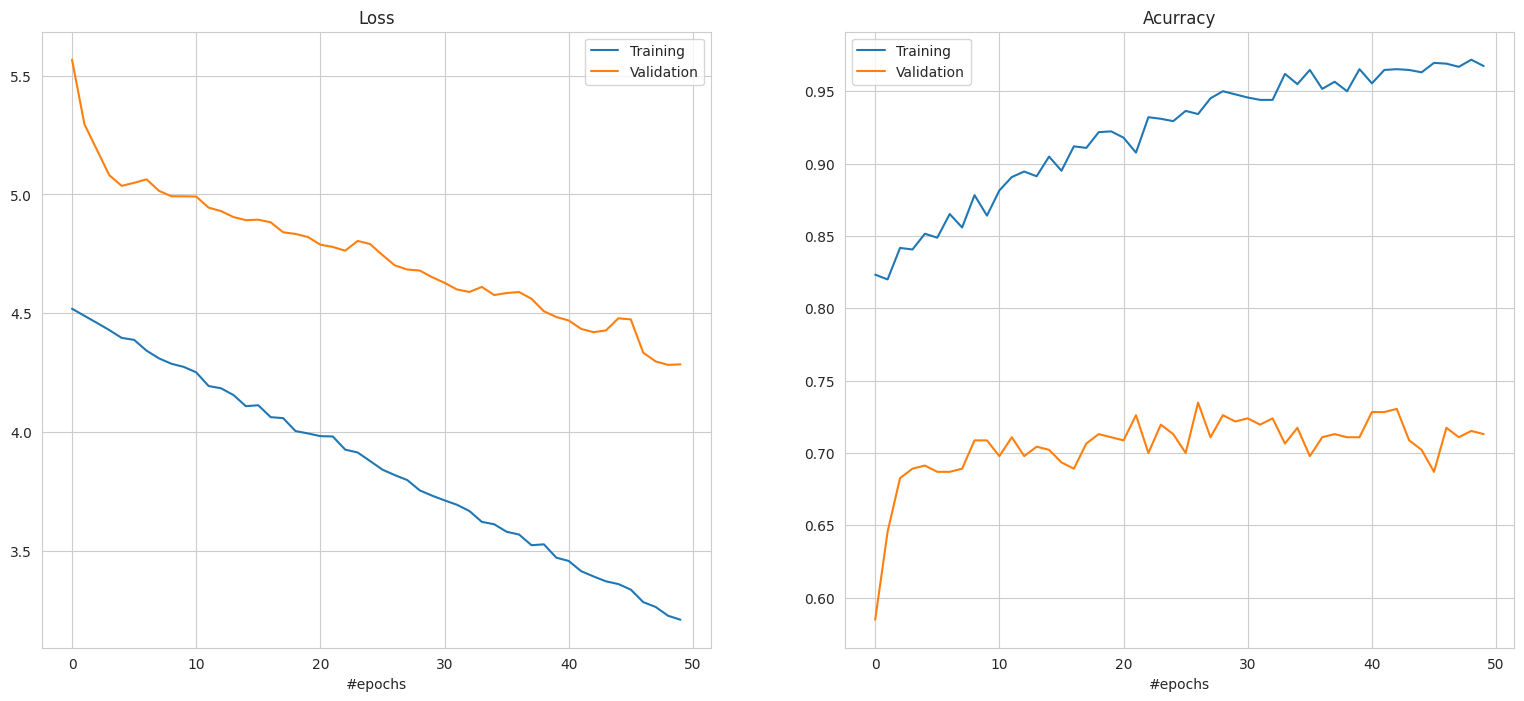

In [20]:
# Plot training loss vs validation loss
sb.set_style('whitegrid')
plt.figure()
fig,(ax1, ax2)=plt.subplots(1,2,figsize=(19,8))
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['Training','Validation'])
ax1.set_title('Loss')
ax1.set_xlabel('#epochs')
## plot training accuracy vs validation accuracy 
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.legend(['Training','Validation'])
ax2.set_title('Acurracy')
ax2.set_xlabel('#epochs')

In [ ]:
# Save the model to a file
model.save('recognition_model_256.h5')  # You can specify any file name and path


In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

# Load and preprocess the image
img_path = '/kaggle/input/pad-ufes-20/PAD-UFES-20/Dataset/PAT_1000_31_620.png'  # Replace with your image path
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = preprocess_input(img_array)  # Preprocess for ResNet50


In [ ]:
# Make predictions
predictions = model.predict(img_array)

# Get the predicted class
predicted_class = np.argmax(predictions, axis=-1)

# Print the result
print(f'Predicted class: {predicted_class[0]}')

In [ ]:
from tensorflow.keras.models import load_model

model_res = load_model('recognition_model.h5')

In [ ]:
# Make predictions
predictions = model.predict(img_array)

# Get the predicted class
predicted_class = np.argmax(predictions, axis=-1)

# Print the result
print(f'Predicted class: {predicted_class[0]}')


In [ ]:
class_names = ['NEV', 'BCC', 'ACK', 'SEK', 'SCC', 'MEL']  # Replace with your class names
predicted_label = class_names[predicted_class[0]]

print(f'Predicted class label: {predicted_label}')

In [ ]:
class_names = ['NEV', 'BCC', 'ACK', 'SEK', 'SCC', 'MEL']  # Replace with your class names
predicted_label = class_names[predicted_class[0]]

print(f'Predicted class label: {predicted_label}')
